# [ATM 623: Climate Modeling](../index.ipynb)

[Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany

# Lecture 17: A peak at numerical methods for diffusion models

### About these notes:

This document uses the interactive [`Jupyter notebook`](https://jupyter.org) format. The notes can be accessed in several different ways:

- The interactive notebooks are hosted on `github` at https://github.com/brian-rose/ClimateModeling_courseware
- The latest versions can be viewed as static web pages [rendered on nbviewer](http://nbviewer.ipython.org/github/brian-rose/ClimateModeling_courseware/blob/master/index.ipynb)
- A complete snapshot of the notes as of May 2017 (end of spring semester) are [available on Brian's website](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2017/Notes/index.html).

[Also here is a legacy version from 2015](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/Notes/index.html).

Many of these notes make use of the `climlab` package, available at https://github.com/brian-rose/climlab

In [1]:
#  Ensure compatibility with Python 2 and 3
from __future__ import print_function, division

## Contents

1. [The one-dimensional diffusion equation](#section1)
2. [Discretizing the diffusion operator in space](#section2)
3. [Coding the discretized diffusion operator in `numpy`](#section3)
4. [Discretizing the time derivative](#section4)
5. [Stability analysis of the FTCS scheme](#section5)
6. [Numerical tests with a shorter timestep](#section6)
7. [The need for a more efficient method](#section7)
8. [Implicit time method](#section8)
9. [Your homework assignment](#section9)

____________
<a id='section1'></a>

## 1. The one-dimensional diffusion equation
____________


Suppose that a quantity $u(x)$ is mixed down-gradient by a diffusive process.

The diffusive flux is

$$ F = - K \frac{\partial u}{\partial x} $$

There will be local changes in $u$ wherever this flux is convergent or divergent:

$$ \frac{\partial u}{\partial t} = - \frac{\partial F}{\partial x} $$

Putting this together gives the classical diffusion equation in one dimension

$$ \frac{\partial u}{\partial t} = \frac{\partial}{\partial x} \left( K \frac{\partial u}{\partial x} \right) $$

For simplicity, we are going to limit ourselves to Cartesian geometry rather than meridional diffusion on a sphere.

We will also assume here that $K$ is a constant, so our governing equation is

$$ \frac{\partial u}{\partial t} = K \frac{\partial^2 u}{\partial x^2} $$

This equation represents a time-dependent diffusion process. It is an **initial-boundary value problem**. We want to integrate the model forward in time to model the changes in the field $u(x)$.


____________
<a id='section2'></a>

## 2. Discretizing the diffusion operator in space
____________



Solving a differential equation on a computer always requires some approximation to represent the continuous function $u(x,t)$ and its derivatives in terms of discrete quantities (arrays of numbers).

We have already dealt with simple discretization of the time derivative back in [Lecture 2](Lecture02 -- Solving the zero-dimensional EBM.ipynb). We used the **forward Euler** method to step all our of radiation models forward in time so far.

### Some notation for discretization of $u(x,t)$

We will discretize time and space on grids

$$ x_j , ~~~ t^n $$

so that 

$$ u_j^n = u(x_j, ~t^n) $$

### Discretizing the diffusive flux

The governing equation can be written in terms of the convergence of the diffusive flux:

$$ \frac{\partial u}{\partial t} = - \frac{\partial F}{\partial x} $$

It is sensible to use a **centered difference** to approximate this derivative:

$$ \frac{\partial F}{\partial x} \bigg|_j \approx  \frac{F_{j+\frac{1}{2}} - F_{j-\frac{1}{2}}}{x_{j+\frac{1}{2}} - x_{j-\frac{1}{2}}} $$

The time tendency at point $x_j$ can thus be written

$$ \frac{\partial u}{\partial t} \bigg|_j  \approx - \frac{F_{j+\frac{1}{2}} - F_{j-\frac{1}{2}}}{x_{j+\frac{1}{2}} - x_{j-\frac{1}{2}}} $$

The flux itself depends on a spatial derivative of $u$. We will apply the same centered difference approximation. At point $x_j$ this would look like

$$ \frac{\partial u}{\partial x} \approx \frac{u_{j+\frac{1}{2}} - u_{j-\frac{1}{2}}}{x_{j+\frac{1}{2}} - x_{j-\frac{1}{2}}} $$

But we actually want to approximate $F_{j+\frac{1}{2}}$ and $F_{j-\frac{1}{2}}$, so we apply the centered difference formula at these intermediate points to get

$$ F_{j+\frac{1}{2}} \approx -K \frac{u_{j+1} - u_{j}}{x_{j+1} - x_{j}} $$

and

$$ F_{j-\frac{1}{2}} \approx -K \frac{u_{j} - u_{j-1}}{x_{j} - x_{j-1}} $$

Putting this all together, we can write the time tendency at $x_j$ as

$$ \frac{\partial u}{\partial t} \bigg|_j  \approx K \frac{ \frac{u_{j+1} - u_{j}}{x_{j+1} - x_{j}} - \frac{u_{j} - u_{j-1}}{x_{j} - x_{j-1}}}{x_{j+\frac{1}{2}} - x_{j-\frac{1}{2}}} $$

We'll make things easy on ourselves by using uniform grid spacing in $x$, so

$$ x_{j+1} - x_{j} = x_{j} - x_{j-1} = x_{j+\frac{1}{2}} - x_{j-\frac{1}{2}} = \Delta x $$

So our final formula for the diffusive flux convergence is

$$ \frac{\partial u}{\partial t} \bigg|_j  \approx K \frac{ u_{j+1} - 2 u_{j} + u_{j-1}}{\Delta x^2} $$

### No-flux boundary conditions

Suppose the domain is $0 \le x \le 1$, with solid walls at $x=0, 1$.

The physical boundary condition at the walls is that there can be no flux in or out of the walls:

$$ F(0) = F(1) = 0 $$

So the boundary conditions on $u$ are

$$ \frac{\partial u}{\partial x} = 0 ~~~ \text{at} ~~~ x=0,1 $$

### The staggered grid

Suppose we have a grid of $J+1$ total points between $x=0$ and $x=1$, **including the boundaries**:

- $x^*_0 = 0 $
- $x^*_1 = \Delta x$
- $x^*_2 = 2~\Delta x$
- ...
- $x^*_j = j~\Delta x$
- ...
- $x^*_{J-1} = (J-1)~\Delta x = 1 - \Delta x $
- $x^*_J = J ~ \Delta x = 1 $

Clearly then the grid spacing must be $\Delta x = 1/J$.

We'll define the fluxes on this grid. The boundary conditions can thus be written

$$ F_0 = F_J = 0 $$

Since our centered difference discretization defines $F$ at points halfway between the $u$ points, it is sensible to locate $u$ on another grid that is offset by $\Delta x / 2$.

The first grid point for $u$ is thus a distance $\Delta x / 2$ from the wall, and there are a total of $J$ points:

- $x_0 = \Delta x / 2$
- $x_1 = \Delta x / 2 + \Delta x$
- $x_2 = \Delta x / 2 + 2~\Delta x$
- ...
- $x_j = \Delta x / 2 + j~\Delta x$
- ...
- $x_{J-1} = \Delta x / 2 + (J-1)~\Delta x = 1 - \Delta x / 2 $

### Implementing the boundary condition on the staggered grid

At $x_0$ we have

$$ \frac{\partial u}{\partial t} \bigg|_0  \approx -\frac{ F_1 - F_0}{\Delta x} $$

Subbing in $F_0 = 0$ and the normal discretization for $F_1$ gives

$$ \frac{\partial u}{\partial t} \bigg|_0  \approx K \frac{ u_1 - u_0 }{\Delta x^2} $$

The same procedure at the other wall yields

$$ \frac{\partial u}{\partial t} \bigg|_{J-1}  \approx - K \frac{ u_{J-1} - u_{J-2} }{\Delta x^2} $$

Pulling this all together we have a complete discretization of the diffusion operator including its boundary conditions:

$$ \frac{\partial u}{\partial t} \bigg|_0  \approx K \frac{ u_1 - u_0 }{\Delta x^2} $$

$$ \frac{\partial u}{\partial t} \bigg|_j  \approx K \frac{ u_{j+1} - 2 u_{j} + u_{j-1}}{\Delta x^2}, ~~~~~~ j=1,...,J-2 $$

$$ \frac{\partial u}{\partial t} \bigg|_{J-1}  \approx - K \frac{ u_{J-1} - u_{J-2} }{\Delta x^2} $$



____________
<a id='section3'></a>

## 3. Coding the discretized diffusion operator in `numpy`
____________



In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math, Latex

Here we will divide our domain up into 20 grid points.

In [3]:
J1 = 20
J = J1
deltax = 1./J
display(Math(r'J = %i' %J))
display(Math(r'\Delta x = %0.3f' %deltax))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

The fluxes will be solved on the staggered grid with 21 points.

$u$ will be solved on the 20 point grid.

In [4]:
xstag = np.linspace(0., 1., J+1)
x = xstag[:-1] + deltax/2
print( x)

[ 0.025  0.075  0.125  0.175  0.225  0.275  0.325  0.375  0.425  0.475
  0.525  0.575  0.625  0.675  0.725  0.775  0.825  0.875  0.925  0.975]


In [5]:
u = np.zeros_like(x)

Here's one way to implement the finite difference, using array indexing.

In [6]:
dudx = (u[1:] - u[:-1]) / (x[1:] - x[:-1])

In [7]:
dudx.shape

(19,)

We can also use the function `numpy.diff()` to accomplish the same thing: 

In [8]:
help(np.diff)

Help on function diff in module numpy.lib.function_base:

diff(a, n=1, axis=-1)
    Calculate the n-th discrete difference along given axis.
    
    The first difference is given by ``out[n] = a[n+1] - a[n]`` along
    the given axis, higher differences are calculated by using `diff`
    recursively.
    
    Parameters
    ----------
    a : array_like
        Input array
    n : int, optional
        The number of times values are differenced.
    axis : int, optional
        The axis along which the difference is taken, default is the last axis.
    
    Returns
    -------
    diff : ndarray
        The n-th differences. The shape of the output is the same as `a`
        except along `axis` where the dimension is smaller by `n`. The
        type of the output is the same as that of the input.
    
    See Also
    --------
    gradient, ediff1d, cumsum
    
    Notes
    -----
    For boolean arrays, the preservation of type means that the result
    will contain `False` when cons

In [9]:
np.diff(u).shape

(19,)

Here is a function that computes the diffusive flux $F$ on the staggered grid, including the boundaries.

In [10]:
def diffusive_flux(u, deltax, K=1):
    #  Take the finite difference
    F = np.diff(u)/deltax
    #  add a zero as the first element (no flux on boundary)
    F = np.insert(F, 0, 0.)
    #  add another zero as the last element (no flux on boundary)
    F = np.append(F, 0.)
    #  flux is DOWN gradient, proportional to D
    return -K*F

In [11]:
diffusive_flux(u,deltax).shape

(21,)

The time tendency of $u$ is just the convergence of this flux, which requires one more finite difference:

In [12]:
def diffusion(u, deltax, K=1):
    #  compute flux
    F = diffusive_flux(u, deltax, K)
    #  take convergence of flux
    return -np.diff(F) / deltax

### A smooth example

Suppose we have an initial $u$ field that has a local maximum in the interior.

The gaussian (bell curve) function is a convenient way to create such a field.

In [13]:
def gaussian(x, mean, std):
    return np.exp(-(x-mean)**2/(2*std**2))/np.sqrt(2*np.pi*std**2)

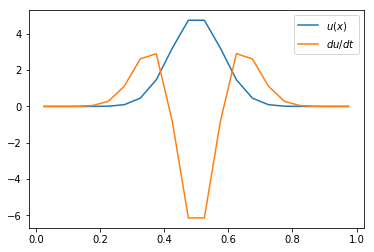

In [14]:
K = 0.01
u = gaussian(x, 0.5, 0.08)
dudt = diffusion(u, deltax, K=K)
fig, ax = plt.subplots(1)
ax.plot(x, u, label='$u(x)$')
ax.plot(x, dudt, label='$du/dt$')
ax.legend()

Hopefully this makes sense. The diffusion is acting to smooth out $u$ by reducing the peak and increasing $u$ on the flanks of the gaussian bump.

### Some non-smooth examples

Use a random number generator to create some noisy initial conditions.

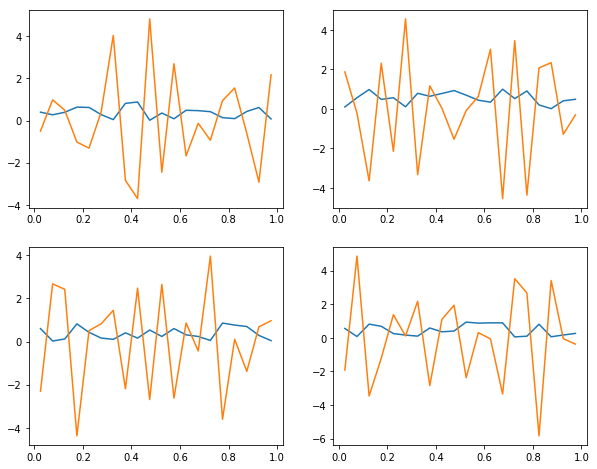

In [15]:
fig = plt.figure(figsize=(10,8))
for n in range(4):
    u = np.random.random(J)
    dudt = diffusion(u, deltax, K)
    ax = fig.add_subplot(2,2,n+1)
    ax.plot(x, u)
    ax.plot(x, dudt)

____________
<a id='section4'></a>

## 4. Discretizing the time derivative
____________




The simplest way to discretize the time derivative is the **forward Euler** method:

$$ \frac{d u}{dt} \bigg|^n \approx \frac{u^{n+1} - u^n}{\Delta t} $$

We have already used this method to step our prognostic variables forward in time.

Solving the above for the future value of $u$ gives

$$ u^{n+1} = u^n + \Delta t \frac{d u}{dt} \bigg|^n $$

We apply our discretization of the diffusion operator to the current value of the field $u^n_j$, to get our formula for the future values:

$$ u_j^{n+1} = u_j^n + \frac{K \Delta t}{\Delta x^2} \left( u^n_{j+1} - 2 u^n_{j} + u^n_{j-1} \right)  $$

(except at the boundaries, where the diffusion operator is slightly different -- see above).

Together, this scheme is known as **Forward Time, Centered Space** or **FTCS**.

It is very simple to implement in `numpy` code.

In [16]:
def step_forward(u, deltax, deltat, K=1):
    dudt = diffusion(u, deltax, K)
    return u + deltat * dudt

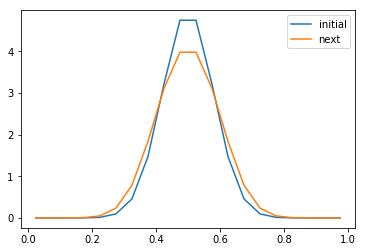

In [17]:
K = 0.01
deltat = 0.125
deltat1 = deltat

u0 = gaussian(x, 0.5, 0.08)
u1 = step_forward(u0, deltax, deltat1, K)
fig, ax = plt.subplots(1)
ax.plot(x, u0, label='initial')
ax.plot(x, u1, label='next')
ax.legend()

Let's loop through a number of timesteps.

In [18]:
#  regular resolution
J = 20
deltax = 1./J
xstag = np.linspace(0., 1., J+1)
x = xstag[:-1] + deltax/2

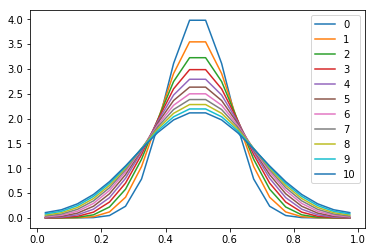

In [19]:
u = gaussian(x, 0.5, 0.08)
niter = 11
for n in range(niter):
    u = step_forward(u, deltax, deltat1, K)
    plt.plot(x, u, label=n)
plt.legend()

The numerics were easy to implement, and the scheme seems to work very well! The results are physically sensible.

### Now, suppose that you wanted to **double** the spatial resolution

Try setting $J=40$ and repeat the above procedure.

What happens?

In [20]:
#  double the resolution
scaling_factor = 2
J = J1 * scaling_factor
deltax = 1./J
xstag = np.linspace(0., 1., J+1)
x = xstag[:-1] + deltax/2

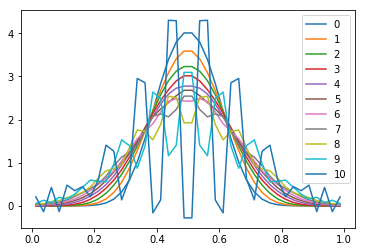

In [21]:
u = gaussian(x, 0.5, 0.08)
for n in range(niter):
    u = step_forward(u, deltax, deltat1, K)
    plt.plot(x, u, label=n)
plt.legend()

Suddenly our scheme is producing numerical noise that grows in time and overwhelms to smooth physical solution we are trying to model.

**This is bad!**

What went wrong, and what can we do about it?

____________
<a id='section5'></a>

## 5. Stability analysis of the FTCS scheme
____________

Following Press et al. (1988), "Numerical Recipes in C: The Art of Scientific Computing", Cambridge University Press.

This is an example of the so-called **von Neumann Stability Analysis**. It is a form of *normal mode* analysis for a discrete system.

We look for normal mode solutions (i.e. wavy sines and cosines) of the finite difference equations of the form

$$ u_j^n = \xi^n \exp(i~k~j~ \Delta x) $$

where $k$ is some real number that represents a spatial wavenumber (which can have any value), and $\xi = \xi(k)$ is a complex number that depends on $k$.

The number $\xi$ is called the **amplification factor** at a given wavenumber $k$.

The question is, **under what conditions do wavy solutions grow with time**?  (This is bad, as it means small numerical noise will become large numerical noise and make our differencing scheme unusable) 

Let's substitute the normal mode solution into our finite difference equation

$$ \frac{u_j^{n+1} -  u_j^n}{\Delta t} = \frac{K}{\Delta x^2} \left( u^n_{j+1} - 2 u^n_{j} + u^n_{j-1} \right)  $$

$$ \frac{\xi^{n+1} \exp(i~k~j~ \Delta x) -  \xi^n \exp(i~k~j~ \Delta x)}{\Delta t} = \frac{K}{\Delta x^2} \left( \xi^n \exp(i~k~(j+1)~ \Delta x) - 2 \xi^n \exp(i~k~j~ \Delta x) + \xi^n \exp(i~k~(j-1)~ \Delta x) \right)  $$

Divide through by $\xi^n \exp(i~k~j~\Delta x)$:

$$ \frac{\xi^{n+1}}{\xi^n} -  1 = \frac{K \Delta t}{\Delta x^2} \left(\exp(i~k~\Delta x) - 2 + \exp(-i~k~\Delta x) \right)  $$

The exponentials simplify

$$ \frac{\xi^{n+1}}{\xi^n} = 1 + \frac{K \Delta t}{\Delta x^2} \left(2 \cos(k~\Delta x) - 2 \right)  $$

Or using a double angle identity,

$$ \frac{\xi^{n+1}}{\xi^n} = 1 - \frac{4 K \Delta t}{\Delta x^2} \sin^2 \left( \frac{k~\Delta x}{2} \right)  $$

### The wavy solution must not grow with time

We need to prevent growing normal modes. So successive amplitudes should be

$$ \bigg| \frac{\xi^{n+1}}{\xi^n} \bigg| \le 1 $$

The stability condition is thus

$$ \bigg| 1 - \frac{4 K \Delta t}{\Delta x^2} \sin^2 \left( \frac{k~\Delta x}{2} \right) \bigg| \le 1 $$

and this condition must be met for **EVERY** possible wavenumber $k$.

Because $0 \le \sin^2(\phi) \le 1$ for any $\phi$, our condition can only be violated if

$$ \frac{4 K \Delta t}{\Delta x^2} > 2 $$

We conclude the the FTCS scheme is stable so long as this stability condition is met:

$$ \Delta t \le \frac{\Delta x^2}{2 K} $$

### We have just discovered an important constraint on the allowable timestep

The maximum timestep we can use with the FTCS scheme for the diffusion equation is proportional to $\Delta x^2$.

** A doubling of the spatial resolution would require a 4x shorter timestep to preserve numerical stability. **

Physically, the restriction is that the maximum allowable timestep is approximately the diffusion time across a grid cell of width $\Delta x$.

____________
<a id='section6'></a>

## 6. Numerical tests with a shorter timestep
____________

Going back to our Gaussian example, let's double the resolution but shorten the timestep by a factor of 4.


In [22]:
#  double the resolution
J = J1 * scaling_factor
deltax = 1./J
xstag = np.linspace(0., 1., J+1)
x = xstag[:-1] + deltax/2

In [23]:
K = 0.01
#  The maximum stable timestep
deltat_max = deltax**2 / 2 / K
print( 'The maximum allowable timestep is %f' %deltat_max)

deltat = deltat1 / scaling_factor**2
print( '4x the previous timestep is %f' %deltat)

The maximum allowable timestep is 0.031250
4x the previous timestep is 0.031250


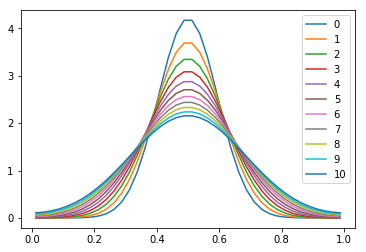

In [24]:
u = gaussian(x, 0.5, 0.08)
for n in range(niter):
    for t in range(scaling_factor**2):
        u = step_forward(u, deltax, deltat, K)
    plt.plot(x, u, label=n)
plt.legend()

Success! The graph now looks like a smoother (higher resolution) version of our first integration with the coarser grid.

**But at a big cost**:  our calculation required 4 times more timesteps to do the same integration.

The total increase in computational cost was actally a factor of 8 to get a factor of 2 increase in spatial resolution.

____________
<a id='section7'></a>

## 7. The need for a more efficient method
____________


In practice the condition

$$ \Delta t \le \frac{\Delta x^2}{2 K} $$

is often too restrictive to be practical!

Consider our diffusive EBM. Suppose we want a spatial resolution of 1º latitude. Then we have 180 grid points from pole to pole, and our physical length scale is 

$$ \Delta x \approx 10^5 \text{m} $$ 

We were using a diffusivity of $ D = 0.6 ~ \text{W m}^{-2}~\text{K}^{-1} $ and a heat capacity of $C = 4 \times 10^7 ~ \text{J m}^{-2} ~\text{K}^{-1}$ (for 10 m of water -- [see Lecture 16](Lecture16 -- Seasonal cycle and heat capacity.ipynb)).

Accounting for the spherical geometry in our EBM, this translates to 

$$ K = \frac{2 \pi a^2 D}{C} = \frac{2 \pi ~ (6.4 \times 10^6 ~\text{m})^2 ~(0.6 ~ \text{W m}^{-2}~\text{K}^{-1})}{4 \times 10^7 ~ \text{J m}^{-2} ~\text{K}^{-1}} \approx 4 \times 10^{6} ~ \text{m}^2 ~ \text{s}^{-1} $$

Recall that this is the diffusivity associated with the large-scale motion of the atmosphere (mostly). If we take a typical velocity scale for a mid-latitude eddy, $V \approx 20~\text{m s}^{-1}$, and a typical length scale for that eddy, $L \approx 2000~\text{km}$, the diffusivity then scales as

$$ K = V~ L = 4 \times 10^{6} ~ \text{m}^2 ~ \text{s}^{-1} $$

Using these numbers the stability condition is roughly

$$ \Delta t \le 10^3 ~\text{s}$$

which is less than one hour!

And if we wanted to double the resolution to 0.5º, we would need a timestep of just a few minutes.

This can be a very onerous requirement for a model that would like to integrate out for many years.  **We can do better, but we need a different time discretization!**

____________
<a id='section8'></a>

## 8. Implicit time method
____________



With numerical methods for partial differential equations, it often turns out that a small change in the discretization can make an enormous difference in the results.

The **implicit time** scheme applies exactly the same centered difference scheme to the spatial derivatives in the diffusion operator.

But instead of applying the operator to the field $u^n$ at time $n$, we instead apply it to the field **at the future time** $u^{n+1}$.

The scheme looks like

$$ \frac{u_j^{n+1} - u_j^n}{\Delta t} =  \frac{K}{\Delta x^2} \left( u^{n+1}_{j+1} - 2 u^{n+1}_{j} + u^{n+1}_{j-1} \right)  $$

in the interior, and at the boundaries:

$$ \frac{u_0^{n+1} - u_0^n}{\Delta t} = \frac{K}{\Delta x^2} \left( u^{n+1}_1 - u^{n+1}_0 \right) $$

and

$$ \frac{u_{J-1}^{n+1} - u_{J-1}^n}{\Delta t} = - \frac{K}{\Delta x^2} \left( u_{J-1}^{n+1} - u_{J-2}^{n+1} \right) $$



This might seem like a strange way to write the system, since **we don't know the future state of the system at $t^{n+1}$**. That's what we're trying to solve for!

Let's move all terms evaluated at $t^{n+1}$ to the left hand side:

$$ u_j^{n+1}  - \frac{K \Delta t}{\Delta x^2} \left( u^{n+1}_{j+1} - 2 u^{n+1}_{j} + u^{n+1}_{j-1} \right) = u_j^n   $$

or

$$ -K^* u^{n+1}_{j+1} + \left(1+2K^* \right) u_j^{n+1} - K^* u_{j-1}^{n+1} = u_j^n $$

(in the interior)

where we have introduced a non-dimensional diffusivity

$$ K^* = \frac{K \Delta t}{\Delta x^2} $$

### The implicit scheme as a matrix problem

We can write this as a matrix equation

$$ \mathbf{A} ~ \mathbf{U}^{n+1} = \mathbf{U}^n $$

where $\mathbf{U}$ is a $J\times1$ column vector giving the field $u(x)$ at a particular instant in time:

$$ \mathbf{U}^n = \left[ \begin{array}{c} 
u^n_0 \\
u^n_1  \\
u^n_2 \\
...  \\
u^n_{J-2} \\
u^n_{J-1} \\
\end{array}
\right] 
$$

and $\mathbf{U}^{n+1}$ is the same vector at $t^{n+1}$.

$\mathbf{A}$ is a $J\times J$ tridiagonal matrix:

$$ \mathbf{A} = \left[ \begin{array}{cccccccc}
 1+K^* & -K^* & 0 & 0 & ... & 0 & 0 & 0 \\
 -K^* & 1+2K^* & -K^* & 0 & ... & 0 & 0 & 0 \\
 0 & -K^* & 1+2K^* & -K^* &... & 0 & 0 & 0 \\
 ... & ... & ... & ... & ... & ... & ... & ... \\
 0 & 0 & 0 & 0 & ... & -K^* & 1+2K^* & -K^* \\
 0 & 0 & 0 & 0 & ... & 0 & -K^* & 1+K^* \\
\end{array}
\right] 
$$

Solving for the future state of the system $\mathbf{U}^{n+1}$ is then just the solution of the linear system

$$ \mathbf{U}^{n+1} = \mathbf{A}^{-1} \mathbf{U}^{n}$$

Solving a tridiagonal matrix problem like this is a very common operation in computer science, and efficient numerical routines are available in many languages (including Python / `numpy`!)

### Stability analysis of the implicit scheme

We'll skip the details, but the amplification factor for this scheme is (see *Numerical Recipes* book or other text on numerical methods):

$$ \frac{\xi^{n+1}}{\xi^n} = \frac{1}{1+4 K^* \sin^2 \left( \frac{k \Delta x}{2} \right) } $$

so the stability criterion of $$ \bigg| \frac{\xi^{n+1}}{\xi^n} \bigg| \le 1 $$

is met for any value of $K^*$ and thus **for any timestep $\Delta t$**.

The implicit method (also called **backward time**) is unconditionally stable for any choice of timestep.

____________
<a id='section9'></a>

## 9. Your homework assignment
____________


Write Python code to solve the diffusion equation using this implicit time method. Demonstrate that it is numerically stable for much larger timesteps than we were able to use with the forward-time method. One way to do this is to use a much higher spatial resolution.

### Some final thoughts:

We have just scratched the surface of the wonders and sorrows of numerical methods here. The implicit method is very **stable** but is not the most **accurate** method for a diffusion problem, particularly when you are interested in some of the faster dynamics of the system (as opposed to just getting the system quickly to its equilibrium state).

There are always trade-offs in the choice of a numerical method.

The equations for most climate models are sufficiently complex that more than one numerical method is necessary. Even in the simple diffusive EBM, the radiation terms are handled by a forward-time method while the diffusion term is solved implicitly.

Once you have worked through the above problem (diffusion only), you might want to look in the `climlab` code to see how the diffusion solver is implemented there, and how it is used when you integrate the EBM.

<div class="alert alert-success">
[Back to ATM 623 notebook home](../index.ipynb)
</div>

____________
## Version information
____________


In [25]:
%load_ext version_information
%version_information numpy, matplotlib

Loading extensions from ~/.ipython/extensions is deprecated. We recommend managing extensions like any other Python packages, in site-packages.


Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.1.0
OS Darwin 16.7.0 x86_64 i386 64bit
numpy 1.13.1
matplotlib 2.0.2
Wed Oct 11 13:46:20 2017 EDT

____________

## Credits

The author of this notebook is [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

It was developed in support of [ATM 623: Climate Modeling](http://www.atmos.albany.edu/facstaff/brose/classes/ATM623_Spring2015/), a graduate-level course in the [Department of Atmospheric and Envionmental Sciences](http://www.albany.edu/atmos/index.php)

Development of these notes and the [climlab software](https://github.com/brian-rose/climlab) is partially supported by the National Science Foundation under award AGS-1455071 to Brian Rose. Any opinions, findings, conclusions or recommendations expressed here are mine and do not necessarily reflect the views of the National Science Foundation.
____________